In [1]:
# references:
# https://pytorch.org/tutorials/prototype/fx_numeric_suite_tutorial.html

In [2]:
import copy

import torch
import torch.ao.ns._numeric_suite_fx as ns
from torch.quantization import get_default_qconfig, quantize_fx
from tqdm import tqdm

from lib.mobilenetv2 import mobilenet_v2
from lib.utils import calibrate, configure_cudnn, prepare_calib_dataloader, prepare_dataloaders, replace_relu, set_seed, test

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
backend = "fbgemm"
torch.backends.quantized.engine = backend

seed = 1000
set_seed(seed)
configure_cudnn(deterministic=True, benchmark=False)

In [4]:
_, test_dataloader = prepare_dataloaders(batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# prepare float model
model = mobilenet_v2()
model.eval()

weight_path = "../models/exp_4000/best_model.pth"
state_dict = torch.load(weight_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
# fuse conv+bn+relu in the model
model_fused = copy.deepcopy(model)

replace_relu(model_fused)

example_inputs = (torch.randn(1, 3, 32, 32),)
qconfig = {
    "": get_default_qconfig(backend),
    "module_name": [
#        ("features.13", None),    
#        ("features.14", None),
#        ("features.15", None),
#        ("features.16", None),
#        ("features.17", None),
    ]
}
model_fused = quantize_fx.prepare_fx(model_fused.eval(), qconfig, example_inputs)  # fuse

# quantize the model
model_quantized = copy.deepcopy(model_fused)
calib_dataloader = prepare_calib_dataloader(batch_size=32)
calibrate(model_quantized, calib_dataloader, n_calib_batch=32)
model_quantized = quantize_fx.convert_fx(model_quantized.eval())  # quantize

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1530: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Files already downloaded and verified


calib: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


In [7]:
test(model_quantized, device="cpu", test_dataloader=test_dataloader)

test: 100%|██████████| 313/313 [00:12<00:00, 25.23it/s]


0.9622

In [8]:
test(model, device="cpu", test_dataloader=test_dataloader)

test: 100%|██████████| 313/313 [00:41<00:00,  7.48it/s]


0.9643

## 1. Compare the weights of float and quantized models

In [9]:
weight_compare_dict = ns.extract_weights(
    "fp32",
    model_fused,
    "int8",
    model_quantized,
)

ns.extend_logger_results_with_comparison(
    weight_compare_dict,  # results object to modify inplace
    "fp32",  # string name of model A (from previous step)
    "int8",  # string name of model B (from previous step)
    torch.ao.ns.fx.utils.compute_sqnr,  # tensor comparison function
    "sqnr",  # the name to use to store the results under
)


In [10]:
weight_compare_results = []
for idx, (layer_name, v) in enumerate(weight_compare_dict.items()):
    weight_compare_results.append({
        "id": idx,
        "layer_name": layer_name,
        "layer_type": v["weight"]["int8"][0]["prev_node_target_type"],
        "weight_shape": v["weight"]["int8"][0]["values"][0].shape,
        "sqnr": v["weight"]["int8"][0]["sqnr"][0],
    })

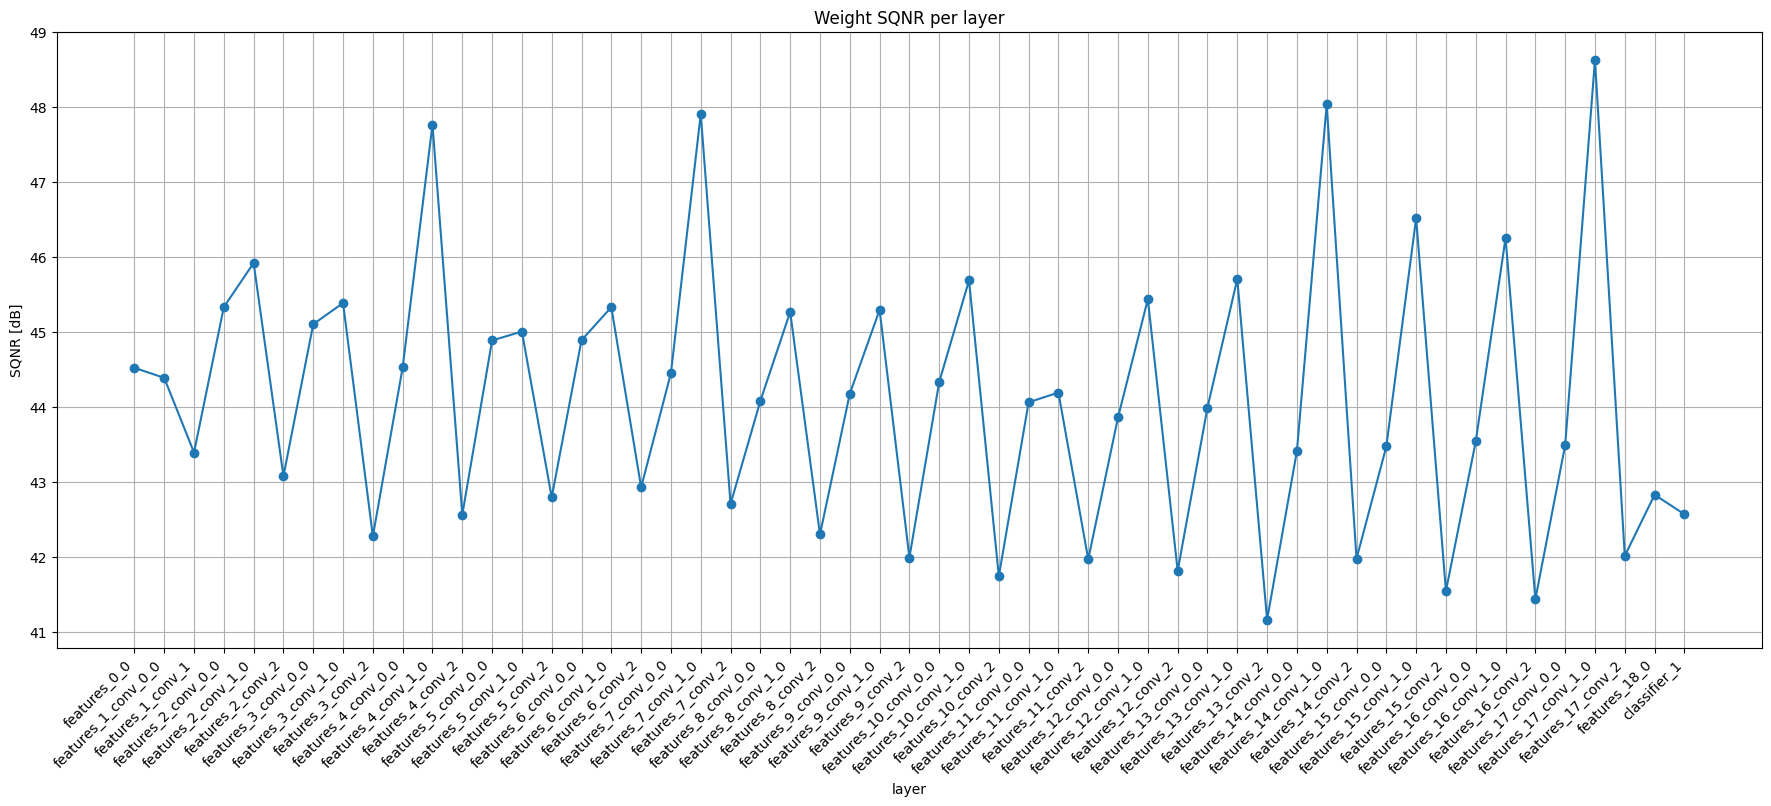

In [11]:
def plot(xdata, ydata, xlabel, ylabel, title):
    import matplotlib.pyplot as plt

    _ = plt.figure(figsize=(22, 8))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.plot(xdata, ydata, marker="o")
    plt.grid()
    plt.show()


plot(
    [x["layer_name"] for x in weight_compare_results],
    [x["sqnr"] for x in weight_compare_results],
    "layer",
    "SQNR [dB]",
    "Weight SQNR per layer"
)

## 2. Compare the activations of float and quantized models

In [12]:
# forward some batches to observe activations
model_fused, model_quantized = ns.add_loggers(
    "fp32",  # string name for model A
    model_fused,  # model A
    "int8",  # string name for model B
    model_quantized,  # model B
    ns.OutputLogger,  # logger class to use
)

batch_count = 0
batch_count_max = 32
calib_dataloader = prepare_calib_dataloader(batch_size=32)
with torch.no_grad():
     for data in tqdm(calib_dataloader, total=batch_count_max):
        inputs = data[0].to(torch.device("cpu"))

        model_fused(inputs)
        model_quantized(inputs)

        batch_count += 1
        if batch_count > batch_count_max:
            break

Files already downloaded and verified


100%|██████████| 32/32 [00:10<00:00,  2.92it/s]


In [13]:
# compute SQNR of the activations
act_compare_dict = ns.extract_logger_info(
    model_fused,  # model A, with loggers (from previous step)
    model_quantized,  # model B, with loggers (from previous step)
    ns.OutputLogger,  # logger class to extract data from
    "int8",  # string name of model to use for layer names for the output
)

ns.extend_logger_results_with_comparison(
    act_compare_dict,  # results object to modify inplace
    "fp32",  # string name of model A (from previous step)
    "int8",  # string name of model B (from previous step)
    torch.ao.ns.fx.utils.compute_sqnr,  # tensor comparison function
    "sqnr",  # the name to use to store the results under
)

act_compare_results = []
for idx, (layer_name, v) in enumerate(act_compare_dict.items()):
    act_compare_results.append({
        "id": idx,
        "layer_name": layer_name,
        "layer_type": v["node_output"]["int8"][0]["prev_node_target_type"],
        "act_shape": v["node_output"]["int8"][0]["values"][0].shape,
        "sqnr": v["node_output"]["int8"][0]["sqnr"][0],
    })

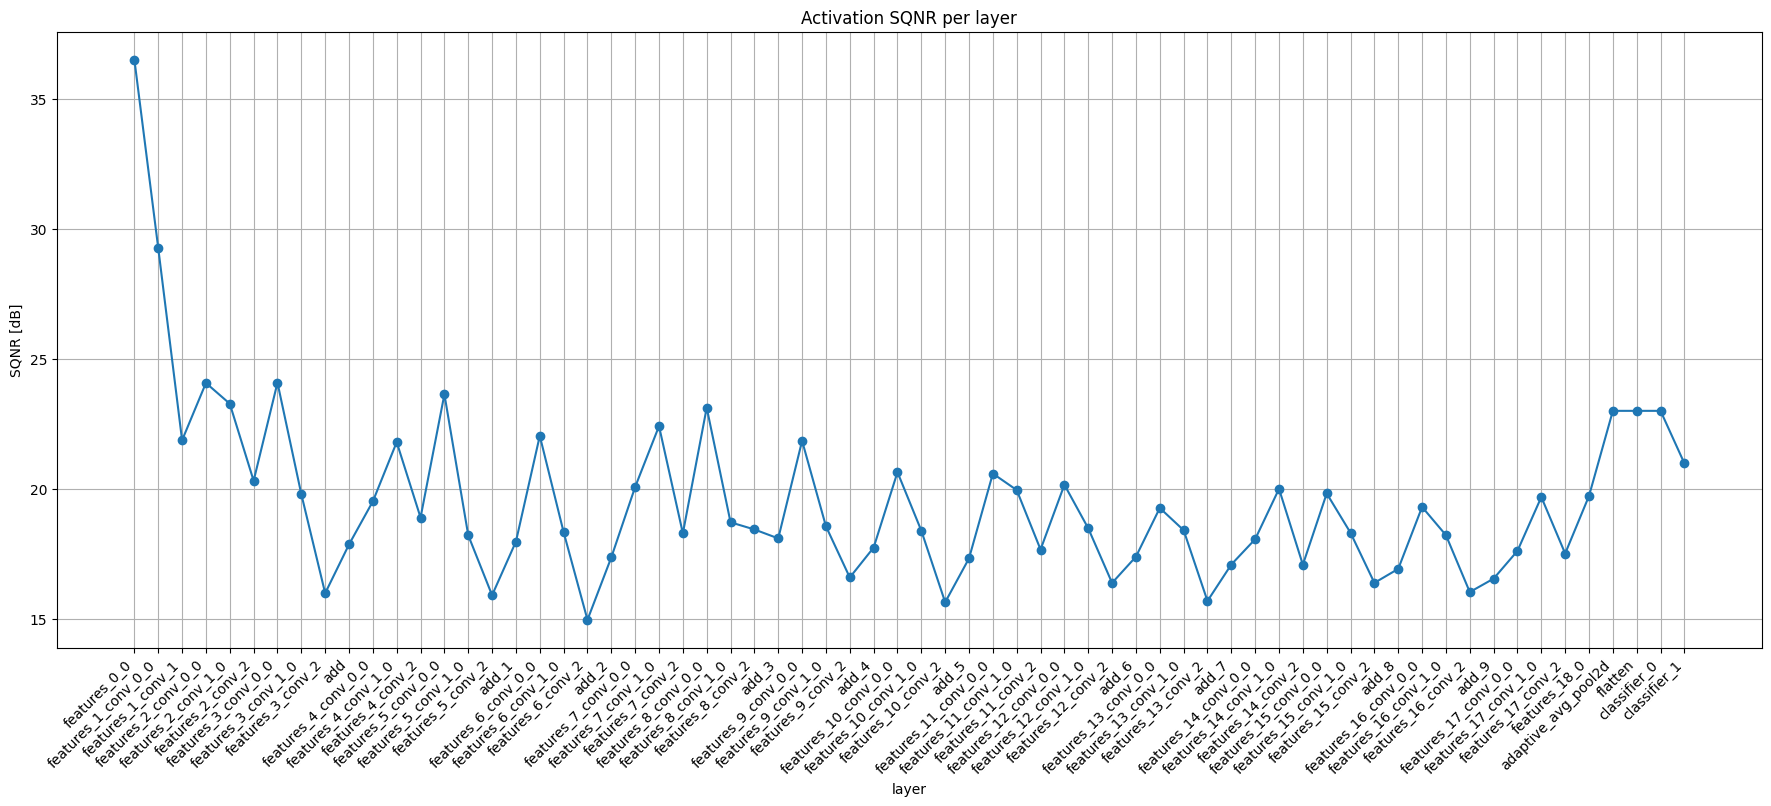

In [14]:
plot(
    [x["layer_name"] for x in act_compare_results],
    [x["sqnr"] for x in act_compare_results],
    "layer",
    "SQNR [dB]",
    "Activation SQNR per layer"
)